In [ ]:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!pip install -q torchmetrics

#a linux command: it's used for machine learning matrics in pytorch (-q: means quite)

In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
!pip install wandb

In [ ]:
# !pip install torchtext==0.17


ERROR: Could not find a version that satisfies the requirement torchtext==0.17 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.16.2, 0.17.2, 0.18.0)
ERROR: No matching distribution found for torchtext==0.17


In [ ]:
import os              #opening files and folders
from glob import glob  #its for finding list of files
import random          #for generating random numbers
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
from PIL import Image
import cv2

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import io
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors
from torchvision.utils import make_grid

# import torchtext
# from torchtext.vocab import build_vocab_from_iterator

import tqdm
import torchmetrics as tm
from torchmetrics import MeanMetric

#Utils

In [ ]:
#calculate the number of trainable parameters of a model
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [ ]:
#measure the time used for training the model on the dataset

def time_for_each_batch(loader):
  start = time.time()            #get the start time
  for iter, (img, mask) in enumerate(loader, 1):  #getting the batches (img and mask are inputs)
    continue
  end = time.time()              # get the end time
  total_time = end - start       #calculate the whole time
  return total_time, total_time/len(loader)   # the time calculated for each batch

dataset

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Arguments

In [ ]:
seed = 8                # for unique results
wandb_enable = False    # it's a tool for monitoring the training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

root = Path('/content/drive/MyDrive/processed/train')

batch_size = 10    # model everytime is trained on 10 samples

In [ ]:
#if monitoring is active, it asks a name for saving.

if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

#dataset

In [ ]:
df = pd.read_csv( '/content/drive/MyDrive/processed/train/metadata.csv')
display(df.head())
df.shape

,input,target,hair,shirt
0,0001.bmp,0001.bmp,blue,blue
1,0001.bmp,0002.bmp,blue,brown
2,0001.bmp,0003.bmp,blue,red
3,0001.bmp,0004.bmp,blue,yellow
4,0001.bmp,0005.bmp,blue,green


(250, 4)

choosing a random sample

In [ ]:
#df.shape[0] --> the whole number of rows
#iloc[idx] --> the number of row
#totally it chooses a random sample from df

idx = random.randint(0, df.shape[0])  #choosing a random row from dataframe (df)
sample = df.iloc[idx]

reading the image and target corresponding to the sample

In [ ]:
from pathlib import Path
import cv2, os

root = Path('/content/drive/MyDrive/processed')

# فرض: sample از df اومده
inp_name = str(sample['input']).strip()
tgt_name = str(sample['target']).strip()

src_path = root / 'train' / 'inputs'  / inp_name
tgt_path = root / 'train' / 'targets' / tgt_name

print("SRC path:", src_path)
print("TGT path:", tgt_path)
print("exists?  ", src_path.exists(), tgt_path.exists())

src = cv2.imread(str(src_path))  #
tgt = cv2.imread(str(tgt_path))

if src is None:
    raise FileNotFoundError(f"Could not read input image: {src_path}")
if tgt is None:
    raise FileNotFoundError(f"Could not read target image: {tgt_path}")

src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
tgt = cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB)


SRC path: /content/drive/MyDrive/processed/train/inputs/0004.bmp
TGT path: /content/drive/MyDrive/processed/train/targets/0091.bmp
exists?   True True


Hair: yellow, Shirt: blue


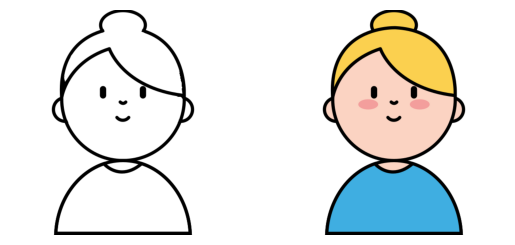

In [ ]:
print(f"Hair: {sample['hair']}, Shirt: {sample['shirt']}")

fig, axes = plt.subplots(1, 2)
axes[0].imshow(src)
axes[0].axis('off')
axes[1].imshow(tgt)
axes[1].axis('off');

printing the color of hair and shirt in the image and target of that sample

In [ ]:
conditions = df['hair'].tolist()    #it takes the columns of hair from df and turns into list
print(conditions)                   # for example result: ['black', 'blond', 'brown', 'red', 'black', ...]


['blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow',

In [ ]:
unique_tokens = sorted(set(conditions))   # ['blue', 'green', 'red', 'yellow']

# string → index
stoi = {token: idx for idx, token in enumerate(unique_tokens)}

# index → string
itos = {idx: token for token, idx in stoi.items()}

vocab = stoi

print("stoi:", stoi)
print("itos:", itos)

# test
sample = {"hair": "green", "shirt": "red"}

embeds = torch.eye(len(vocab))
hair_idx, shirt_idx = vocab[sample['hair']], vocab[sample['shirt']]

print("Hair one-hot:", embeds[hair_idx])
print("Shirt one-hot:", embeds[shirt_idx])


stoi: {'blue': 0, 'brown': 1, 'green': 2, 'red': 3, 'yellow': 4}
itos: {0: 'blue', 1: 'brown', 2: 'green', 3: 'red', 4: 'yellow'}
Hair one-hot: tensor([0., 0., 1., 0., 0.])
Shirt one-hot: tensor([0., 0., 0., 1., 0.])


In [ ]:
embeds = torch.eye(len(vocab))   #
hair_idx, shirt_idx = vocab[sample['hair']], vocab[sample['shirt']]   #

embeds[hair_idx], embeds[shirt_idx]   #

# sample['shirt']  # خروجی: 'red'
# vocab[sample['shirt']] -->
# vocab['red']  # خروجی: 3
# vocab[sample['shirt']] -->
# embeds[shirt_idx]-->

(tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0.]))

#Custom dataset

In [ ]:
from torchvision.datasets import VisionDataset
from typing import Optional, Callable
from pathlib import Path
from PIL import Image
import torch
import pandas as pd
import torchvision.tv_tensors as tv_tensors

class ImageTranslationDataset(VisionDataset):

    def __init__(self, root: str,
                 transforms: Optional[Callable] = None,
                 memory: bool = False):

        super().__init__(root, transforms=transforms)

        self.input_folder = Path(root) / 'inputs'
        self.target_folder = Path(root) / 'targets'

        self.df = pd.read_csv(Path(root) / 'metadata.csv')

        metadata = self.df['hair'].tolist() + self.df['shirt'].tolist()
        unique_tokens = sorted(set(metadata))
        self.vocab = {token: idx for idx, token in enumerate(unique_tokens)}

        self.embeds = torch.eye(len(self.vocab))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]

        input_image = self._load_image(self.input_folder / sample['input'])
        target_image = self._load_image(self.target_folder / sample['target'])

        hair, shirt = str(sample['hair']).strip(), str(sample['shirt']).strip()

        hair_idx, shirt_idx = self.vocab[hair], self.vocab[shirt]

        condition = self.embeds[[hair_idx, shirt_idx]]
        condition = condition.view(-1, 1, 1)  # (C,1,1)

        if self.transforms:
            input_image, target_image = self.transforms(input_image, target_image)

        return input_image, target_image, condition

    def _load_image(self, path):
        img = Image.open(path).convert("RGB")
        return tv_tensors.Image(img)

    def __repr__(self):
        return f'Number of datapoints: {len(self)}'


In [ ]:
transform_train = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

transform_valid = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

In [ ]:
train_set = ImageTranslationDataset(root / 'train', transform_train)
valid_set = ImageTranslationDataset(root / 'test', transform_valid)
train_set, valid_set

(Number of datapoints: 250, Number of datapoints: 100)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

len(train_loader), len(valid_loader)  #

(8, 4)

In [ ]:
imgs, tgts, conds = next(iter(train_loader))
print(imgs.shape, tgts.shape, conds.shape)  # مثلاً: (32, 3, 256, 256), (32, 3, 256, 256), (32, C, 1, 1)


torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256]) torch.Size([32, 10, 1, 1])


torch.Size([10, 1, 1])


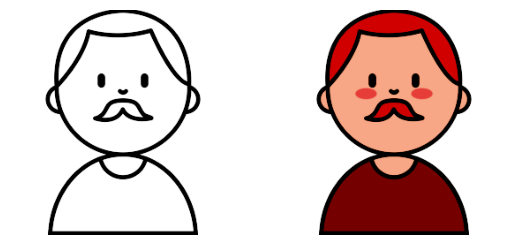

In [ ]:
idx = random.randint(0, len(train_set)-1)      #a random sample between 0 and the last index
src, tgt, vecs = train_set[idx]                # coz of getitem, train_set[idx] has three outputs.

fig, axes = plt.subplots(1, 2)
axes[0].imshow(src.permute(1, 2, 0)), axes[0].axis('off')
axes[1].imshow(tgt.permute(1, 2, 0)), axes[1].axis('off');

print(vecs.shape)

#DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [ ]:
imgs, tgts, txts = next(iter(train_loader))
imgs.shape, tgts.shape, txts.shape

(torch.Size([10, 3, 256, 256]),
 torch.Size([10, 3, 256, 256]),
 torch.Size([10, 10, 1, 1]))

In [ ]:
imgs, tgts, txts = next(iter(valid_loader))
imgs.shape, tgts.shape, txts.shape

(torch.Size([10, 3, 256, 256]),
 torch.Size([10, 3, 256, 256]),
 torch.Size([10, 10, 1, 1]))

#Model

#generator

encoder block

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, batchnorm=True):    #class creator
    super().__init__()                #prepare the internal part of module
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if batchnorm else None
    self.af = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.af(x)
    return x

In [ ]:
#texting the block above

encoder_block = EncoderBlock(in_channels=3, out_channels=64, kernel_size=4, batchnorm=True)
with torch.no_grad():
  tmp = encoder_block(torch.randn(1, 3, 256, 256))  ##
tmp.shape    #(1, 64, 128, 128)

torch.Size([1, 64, 128, 128])

decoder block

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, dropout=False):
    super().__init__()

    self.tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout(0.5) if dropout else None   #dropout to prevent from overfitting
    self.af = nn.ReLU()

  def forward(self, x):
    x = self.tconv(x)
    x = self.bn(x)
    if self.dropout:
      x = self.dropout(x)
    x = self.af(x)
    return x

In [ ]:
decoder_block = DecoderBlock(in_channels=512, out_channels=256, dropout=False)
tmp = decoder_block(torch.randn(2, 512, 4, 4))
tmp.shape

torch.Size([2, 256, 8, 8])

#Unet

In [ ]:
class Generator(nn.Module):

  def __init__(self, in_channels=13):
    super().__init__()

    # Encoder (Making it small + feature extraction)
    nc = [in_channels, 64, 128, 256, 512, 512, 512, 512, 512]
    self.encoders = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=False if i==1 else True) for i in range(1, len(nc))
    ])


    # Decoder
    nc.reverse()
    self.decoders = nn.ModuleList([
        DecoderBlock(2*nc[i-1] if i>1 else nc[i-1], nc[i], dropout=True if i<4 else False) for i in range(1, len(nc[:-1]))
    ])
    self.last = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
    self.tanh = nn.Tanh()

  def forward(self, x, c):
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, c), dim=1)

    # Encoder
    skips = []
    for encoder in self.encoders:
      x = encoder(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder
    for decoder, skip in zip(self.decoders, skips):
      x = decoder(x)
      x = torch.cat((x, skip), 1)

    out = self.last(x)
    out = self.tanh(out)

    return out

In [ ]:
generator = Generator(in_channels=13)
tmp = generator(torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape  #(batch, 3, 256, 256)

torch.Size([2, 3, 256, 256])

In [ ]:
generator

Generator(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): EncoderBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): EncoderBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): EncoderBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_sl

#Discriminator

**Basic block** is similar to EncoderBlock in Generator.

In [ ]:
class BasicBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, batchnorm=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if batchnorm else None
    self.af = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.af(x)
    return x

In [ ]:
basic_block = BasicBlock(in_channels=3, out_channels=64, kernel_size=4, batchnorm=True)
with torch.no_grad():
  tmp = basic_block(torch.randn(1, 3, 256, 256))
tmp.shape

torch.Size([1, 64, 128, 128])

#Main discriminator

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, in_channels=16):
    super().__init__()

    # first layer without batchnormalization
    nc = [in_channels, 64, 128, 256]
    self.layers = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=True if i>1 else False) for i in range(1, len(nc))
    ])

    self.layers += nn.Sequential(
        nn.ZeroPad2d(padding=1),
        nn.Conv2d(256, 512, kernel_size=4, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2))

    self.layers += nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size=4)
    )

  def forward(self, x, y, c):
    # Concat
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, y, c), dim=1)

    for layer in self.layers:
      x = layer(x)      #(B, 1, H_out, W_out)
    return x

In [ ]:
discriminator = Discriminator(in_channels=16)
tmp = discriminator(torch.randn(2, 3, 256, 256), torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape

torch.Size([2, 1, 30, 30])

In [ ]:
discriminator

Discriminator(
  (layers): ModuleList(
    (0): EncoderBlock(
      (conv): Conv2d(16, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): EncoderBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): EncoderBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ZeroPad2d((1, 1, 1, 1))
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7

#Final: Creating Discriminator and Generator

In [ ]:
generator = Generator(in_channels=13)
discriminator = Discriminator(in_channels=16)

In [ ]:
x, y, c = next(iter(train_loader))  #x: input/ y:target/c: one hot
print(x.shape, y.shape, c.shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 256, 256]) torch.Size([10, 10, 1, 1])


In [ ]:
tmp = generator(x, c)   #G(x)
tmp.shape

torch.Size([10, 3, 256, 256])

we have two modes for discriminator

In [ ]:
tmp = discriminator(x, y, c)  #x: sketch (main input)
tmp.shape

torch.Size([10, 1, 30, 30])

In [ ]:
tmp = discriminator(x, generator(x, c), c)
tmp.shape

torch.Size([10, 1, 30, 30])

#Config

Loss_Generator

In [ ]:
class GeneratorLoss(nn.Module):

  def __init__(self, LAMBDA=100):
    super().__init__()
    self.LAMBDA = LAMBDA
    self.l1 = nn.L1Loss()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_generated_output, gen_output, target):
    l1_loss = self.l1(gen_output, target)



    all_ones = torch.ones_like(disc_generated_output)
    gan_loss = self.bce(disc_generated_output, all_ones)

    total_gan_loss = gan_loss + self.LAMBDA * l1_loss

    return total_gan_loss

In [ ]:
loss_g = GeneratorLoss(LAMBDA=100)
loss_g

GeneratorLoss(
  (l1): L1Loss()
  (bce): BCEWithLogitsLoss()
)

In [ ]:
x, y, c = next(iter(train_loader))
g_x = generator(x, c)
d_g_x = discriminator(x, g_x, c)
loss_g(d_g_x, g_x, y)

tensor(80.9170, grad_fn=<AddBackward0>)

Loss_discriminator

In [ ]:
class DiscriminatorLoss(nn.Module):

  def __init__(self):
    super().__init__()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_real_output, disc_generated_output):

    #for real input
    all_ones = torch.ones_like(disc_real_output)
    real_loss = self.bce(disc_real_output, all_ones)

    #for fake input
    all_zeros = torch.zeros_like(disc_generated_output)
    generated_loss = self.bce(disc_generated_output, all_zeros)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
loss_d = DiscriminatorLoss()
loss_d

DiscriminatorLoss(
  (bce): BCEWithLogitsLoss()
)

In [ ]:
x, y, c = next(iter(train_loader))
g_x = generator(x, c)
d_g_x = discriminator(x, g_x, c)
d_x = discriminator(x, y, c)
loss_d(d_x, d_g_x)

tensor(1.4380, grad_fn=<AddBackward0>)

#Optimizer

In [ ]:
optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

#Train

In [ ]:
def train_one_epoch(generator, discriminator,
                    train_loader,
                    generator_loss_fn, discriminator_loss_fn,
                    generator_optimizer, discriminator_optimizer,
                    epoch=None):

  generator.train()
  discriminator.train()

  gen_total_loss, disc_total_loss = MeanMetric(), MeanMetric()

 #tqdm-->prgress bar
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets, conditions in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      # Generator's loss
      gen_outputs = generator(inputs, conditions)
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      gen_loss = generator_loss_fn(disc_gen_outputs, gen_outputs, targets)


      gen_outputs = generator(inputs, conditions).detach()        #
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      disc_real_outputs = discriminator(inputs, targets, conditions)
      disc_loss = discriminator_loss_fn(disc_real_outputs, disc_gen_outputs) #

      # Generator's params update
      generator_optimizer.zero_grad()   # gradients become zero
      gen_loss.backward()
      generator_optimizer.step()        #Adam generator step forwards

      # Discriminator's params update
      discriminator_optimizer.zero_grad()
      disc_loss.backward()
      discriminator_optimizer.step()

      gen_total_loss.update(gen_loss.item(), weight=len(inputs))
      disc_total_loss.update(disc_loss.item(), weight=len(inputs))

      tepoch.set_postfix(
          lossG=gen_total_loss.compute().item(),
          lossD=disc_total_loss.compute().item()
          )

  return gen_total_loss.compute().item(), disc_total_loss.compute().item()

#Evaluation:

In [ ]:
def evaluate(generator, test_loader, loss_fn):

  loss_eval = MeanMetric()

  with torch.inference_mode():
    for inputs, targets, conditions in test_loader:   #getting batches from testloader

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      outputs = generator(inputs, conditions)     #

      loss = loss_fn(outputs, targets)            #MSE (compare between gen output and target)
      loss_eval.update(loss.item(), weight=len(targets))

  return loss_eval.compute().item()

#Generate

In [ ]:
def generate(generator, valid_loader, filename='img.png'):

  inputs, targets, conditions = next(iter(valid_loader))
  inputs = inputs.to(device)
  conditions = conditions.to(device)

  with torch.inference_mode():
    outputs = generator(inputs, conditions)

  outputs = (255*(0.5*outputs + 0.5)).byte().cpu()
  targets = (255*(0.5*targets + 0.5)).byte().cpu()

  imgs = [t for t in targets] + [o for o in outputs]
  grid = make_grid(imgs, nrow=10)
  io.write_png(grid, filename)

In [ ]:
generate(generator.cuda(), valid_loader)

#Main Loop

In [ ]:
torch.cuda.empty_cache()  #

In [ ]:
set_seed(seed)

#Building models
generator = Generator(in_channels=13).to(device)
discriminator = Discriminator(in_channels=16).to(device)

In [ ]:
gen_loss_fn = GeneratorLoss(LAMBDA=100)
disc_loss_fn = DiscriminatorLoss()

In [ ]:
set_seed(seed)

lr = 0.0002
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

In [ ]:
loss_gen_hist = []
loss_disc_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
from pathlib import Path
import os

RESULTS_DIR = Path('/content/drive/MyDrive/processed/results')
WEIGHTS_DIR = Path('/content/drive/MyDrive/processed/weights')

# RESULTS_DIR = Path('results')
# WEIGHTS_DIR = Path('weights')

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# RESULTS_DIR.mkdir(parents=True, exist_ok=True)
# WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
num_epochs = 50       #
generate(generator, valid_loader, f'results/img-0.png')

num_epochs = 50
generate(generator, valid_loader, str(RESULTS_DIR / 'img-0.png'))

for epoch in range(num_epochs):
  # Train
  gen_loss, disc_loss = train_one_epoch(
      generator, discriminator,
      train_loader,
      gen_loss_fn, disc_loss_fn,
      gen_optimizer, disc_optimizer,
      epoch+1)

  # Validation
  loss_valid = evaluate(
      generator,
      valid_loader,
      nn.MSELoss())

  generate(generator, valid_loader, str(RESULTS_DIR / f'img-{epoch+1}.png'))

  loss_gen_hist.append(gen_loss)
  loss_disc_hist.append(disc_loss)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(generator, str(WEIGHTS_DIR / 'generator-best.pt'))
    best_loss_valid = loss_valid
    print('Generator Saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()
  epoch_counter += 1

torch.save(generator, f'generator-last.pt')  #saving the last epoch

Epoch 1: 100%|██████████| 25/25 [00:17<00:00,  1.47batch/s, lossD=1.36, lossG=37.8]


Generator Saved!
Valid: Loss = 0.1117



Epoch 2: 100%|██████████| 25/25 [00:20<00:00,  1.24batch/s, lossD=1.17, lossG=15.8]


Generator Saved!
Valid: Loss = 0.0652



Epoch 3: 100%|██████████| 25/25 [00:20<00:00,  1.24batch/s, lossD=1.21, lossG=11.8]


Generator Saved!
Valid: Loss = 0.04816



Epoch 4: 100%|██████████| 25/25 [00:21<00:00,  1.17batch/s, lossD=1.24, lossG=9.78]


Generator Saved!
Valid: Loss = 0.03543



Epoch 5: 100%|██████████| 25/25 [00:21<00:00,  1.17batch/s, lossD=1.21, lossG=8.72]


Generator Saved!
Valid: Loss = 0.03435



Epoch 6: 100%|██████████| 25/25 [00:21<00:00,  1.17batch/s, lossD=1.28, lossG=7.39]


Generator Saved!
Valid: Loss = 0.02982



Epoch 7: 100%|██████████| 25/25 [00:20<00:00,  1.20batch/s, lossD=1.32, lossG=7.01]


Valid: Loss = 0.03044



Epoch 8: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.37, lossG=6.65]


Generator Saved!
Valid: Loss = 0.02512



Epoch 9: 100%|██████████| 25/25 [00:20<00:00,  1.23batch/s, lossD=1.32, lossG=5.93]


Valid: Loss = 0.02846



Epoch 10: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.35, lossG=5.86]


Valid: Loss = 0.02624



Epoch 11: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.35, lossG=5.8]


Generator Saved!
Valid: Loss = 0.02317



Epoch 12: 100%|██████████| 25/25 [00:20<00:00,  1.20batch/s, lossD=1.34, lossG=4.93]


Valid: Loss = 0.02322



Epoch 13: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.27, lossG=5.33]


Valid: Loss = 0.02329



Epoch 14: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.36, lossG=4.93]


Valid: Loss = 0.02667



Epoch 15: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.35, lossG=4.53]


Valid: Loss = 0.02689



Epoch 16: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.27, lossG=4.64]


Valid: Loss = 0.02364



Epoch 17: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.34, lossG=4.59]


Valid: Loss = 0.02407



Epoch 18: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.35, lossG=4.52]


Generator Saved!
Valid: Loss = 0.02174



Epoch 19: 100%|██████████| 25/25 [00:21<00:00,  1.15batch/s, lossD=1.36, lossG=3.99]


Valid: Loss = 0.02327



Epoch 20: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.29, lossG=4.33]


Generator Saved!
Valid: Loss = 0.01911



Epoch 21: 100%|██████████| 25/25 [00:20<00:00,  1.19batch/s, lossD=1.35, lossG=3.84]


Valid: Loss = 0.02005



Epoch 22: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.37, lossG=3.71]


Valid: Loss = 0.01943



Epoch 23: 100%|██████████| 25/25 [00:16<00:00,  1.50batch/s, lossD=1.34, lossG=3.6]


Valid: Loss = 0.02046



Epoch 24: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.32, lossG=3.8]


Valid: Loss = 0.021



Epoch 25: 100%|██████████| 25/25 [00:16<00:00,  1.49batch/s, lossD=1.3, lossG=3.81]


Valid: Loss = 0.02087



Epoch 26: 100%|██████████| 25/25 [00:16<00:00,  1.54batch/s, lossD=1.33, lossG=3.78]


Valid: Loss = 0.02056



Epoch 27: 100%|██████████| 25/25 [00:16<00:00,  1.49batch/s, lossD=1.36, lossG=3.43]


Valid: Loss = 0.02066



Epoch 28: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.31, lossG=3.44]


Valid: Loss = 0.01931



Epoch 29: 100%|██████████| 25/25 [00:17<00:00,  1.46batch/s, lossD=1.35, lossG=3.31]


Valid: Loss = 0.02004



Epoch 30: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.28, lossG=3.34]


Valid: Loss = 0.02152



Epoch 31: 100%|██████████| 25/25 [00:16<00:00,  1.48batch/s, lossD=1.31, lossG=3.77]


Valid: Loss = 0.02454



Epoch 32: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.29, lossG=3.84]


Valid: Loss = 0.01995



Epoch 33: 100%|██████████| 25/25 [00:16<00:00,  1.49batch/s, lossD=1.3, lossG=3.57]


Generator Saved!
Valid: Loss = 0.01853



Epoch 34: 100%|██████████| 25/25 [00:20<00:00,  1.20batch/s, lossD=1.34, lossG=3.24]


Valid: Loss = 0.01932



Epoch 35: 100%|██████████| 25/25 [00:16<00:00,  1.54batch/s, lossD=1.33, lossG=3.08]


Valid: Loss = 0.01903



Epoch 36: 100%|██████████| 25/25 [00:16<00:00,  1.50batch/s, lossD=1.36, lossG=3.13]


Valid: Loss = 0.02012



Epoch 37: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.34, lossG=3.02]


Generator Saved!
Valid: Loss = 0.01798



Epoch 38: 100%|██████████| 25/25 [00:21<00:00,  1.18batch/s, lossD=1.32, lossG=3.01]


Valid: Loss = 0.01971



Epoch 39: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.32, lossG=2.91]


Valid: Loss = 0.01851



Epoch 40: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.45, lossG=2.76]


Valid: Loss = 0.01821



Epoch 41: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.35, lossG=2.78]


Valid: Loss = 0.01911



Epoch 42: 100%|██████████| 25/25 [00:16<00:00,  1.49batch/s, lossD=1.37, lossG=2.79]


Generator Saved!
Valid: Loss = 0.01735



Epoch 43: 100%|██████████| 25/25 [00:21<00:00,  1.17batch/s, lossD=1.36, lossG=2.73]


Valid: Loss = 0.01817



Epoch 44: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.37, lossG=2.65]


Valid: Loss = 0.01816



Epoch 45: 100%|██████████| 25/25 [00:16<00:00,  1.53batch/s, lossD=1.36, lossG=2.66]


Valid: Loss = 0.01907



Epoch 46: 100%|██████████| 25/25 [00:16<00:00,  1.51batch/s, lossD=1.34, lossG=2.58]


Valid: Loss = 0.01741



Epoch 47: 100%|██████████| 25/25 [00:16<00:00,  1.55batch/s, lossD=1.36, lossG=2.55]


Valid: Loss = 0.01765



Epoch 48: 100%|██████████| 25/25 [00:16<00:00,  1.52batch/s, lossD=1.39, lossG=2.44]


Valid: Loss = 0.01868



Epoch 49: 100%|██████████| 25/25 [00:16<00:00,  1.54batch/s, lossD=1.39, lossG=2.37]


Valid: Loss = 0.01776



Epoch 50: 100%|██████████| 25/25 [00:16<00:00,  1.50batch/s, lossD=1.35, lossG=2.49]


Valid: Loss = 0.01757



In [ ]:
import torch
import torch.serialization

torch.serialization.add_safe_globals([Generator])

path = WEIGHTS_DIR / 'generator-best.pt'
best_g = torch.load(path, map_location=device, weights_only=False).eval()
generate(best_g, valid_loader, RESULTS_DIR / 'img-best.png')


In [ ]:
best_g = Generator(in_channels=13).to(device)   #
sd = torch.load(WEIGHTS_DIR / 'generator-best.pth', map_location=device, weights_only=True)
best_g.load_state_dict(sd, strict=True)
best_g.eval()

generate(best_g, valid_loader, RESULTS_DIR / 'img-best.png')

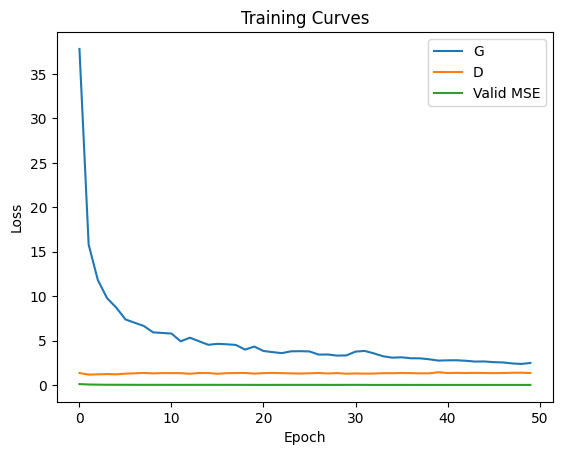

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_gen_hist, label='G')
plt.plot(loss_disc_hist, label='D')
plt.plot(loss_valid_hist, label='Valid MSE')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Curves')
plt.show()

In [ ]:
best_g = torch.load(WEIGHTS_DIR / 'generator-best.pt', map_location=device).eval()
generate(best_g, valid_loader, RESULTS_DIR / 'img-best.png')


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.ModuleList was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.nn.modules.container.ModuleList])` or the `torch.serialization.safe_globals([torch.nn.modules.container.ModuleList])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

#Plot

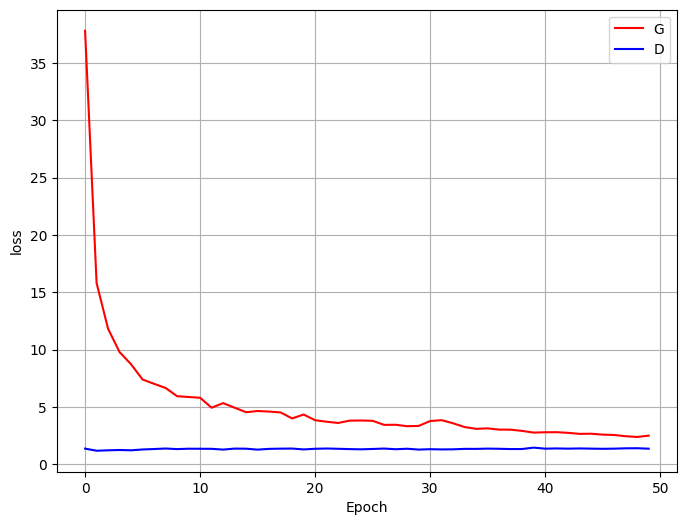

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_gen_hist, 'r-', label='G')
plt.plot(range(epoch_counter), loss_disc_hist, 'b-', label='D')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#Generate

In [ ]:
import torch
from pathlib import Path

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # مسیر فایل وزن‌ها
# weights_path = Path("/content/drive/MyDrive/processed/weights/generator-best.pt")

# # حتما قبلش class Generator تعریف شده باشه
# generator = torch.load(weights_path, map_location=device)
# generator.eval()
# print("Model loaded and set to eval mode!")


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.ModuleList was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.nn.modules.container.ModuleList])` or the `torch.serialization.safe_globals([torch.nn.modules.container.ModuleList])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
import torch, torch.nn as nn
import torch.serialization

torch.serialization.add_safe_globals([
    Generator, EncoderBlock, DecoderBlock,  #
    nn.ModuleList, nn.Sequential            #
])

path = WEIGHTS_DIR / 'generator-best.pt'  # مسیر فایل .pt
generator = torch.load(path, map_location=device, weights_only=False)
generator.eval()
print("Loaded OK.")


Loaded OK.


In [ ]:
torch.save(generator.state_dict(), WEIGHTS_DIR / 'generator-best.pth')


In [ ]:
best_g = Generator(in_channels=13).to(device)
best_g.load_state_dict(torch.load(WEIGHTS_DIR/'generator-best.pth', map_location=device, weights_only=True))
best_g.eval()


Generator(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): EncoderBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): EncoderBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): EncoderBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_sl

In [ ]:
import pandas as pd
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/processed")
csv_path = ROOT / 'train' / 'metadata.csv'
df = pd.read_csv(csv_path)

hair_vals  = sorted(set(str(x).strip() for x in df['hair']))
shirt_vals = sorted(set(str(x).strip() for x in df['shirt']))
print("hair:", hair_vals)
print("shirt:", shirt_vals)


hair: ['blue', 'brown', 'green', 'red', 'yellow']
shirt: ['blue', 'brown', 'green', 'red', 'yellow']


In [ ]:
def make_condition(hair, shirt, device):
    C = len(stoi)                 # 5
    eye = torch.eye(C, device=device)
    one_hair  = eye[stoi[hair]]   # (C,)
    one_shirt = eye[stoi[shirt]]  # (C,)
    cond = torch.cat([one_hair, one_shirt], dim=0)  #
    return cond.view(1, 2*C, 1, 1)                  #


In [ ]:
img_path = ROOT / 'test' / 'inputs' / '0001.bmp'
x = transform_valid(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)

# یکی از رنگ‌های مجاز: ['blue','brown','green','red','yellow']
c = make_condition('brown', 'blue', device)  # -> (1,10,1,1)

with torch.inference_mode():
    y = generator(x, c)   #

y = denorm_0_255(y.squeeze(0).cpu())
io.write_png(y, str(ROOT / 'results' / 'pred-0001.png'))
print("Saved:", ROOT / 'results' / 'pred-0001.png')


Saved: /content/drive/MyDrive/processed/results/pred-0001.png


In [ ]:
from pathlib import Path
from PIL import Image
import torchvision.transforms.v2 as v2
import torchvision.io as io
import pandas as pd
import torch
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ROOT = Path("/content/drive/MyDrive/processed")

(ROOT / "results").mkdir(parents=True, exist_ok=True)

transform_valid = v2.Compose([
    v2.Resize((256, 256), antialias=True),
    v2.ToImage(),                             #
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

csv_path = ROOT / 'train' / 'metadata.csv'
df = pd.read_csv(csv_path)
tokens = (df['hair'].astype(str).tolist() + df['shirt'].astype(str).tolist())
stoi = {t:i for i,t in enumerate(sorted(set(tokens)))}
# مثلا: ['blue','brown','green','red','yellow']  => len(stoi)=5

def make_condition(hair: str, shirt: str, device='cpu'):
    C = len(stoi)                  # 5
    eye = torch.eye(C, device=device)
    one_hair  = eye[stoi[hair]]    # (C,)
    one_shirt = eye[stoi[shirt]]   # (C,)
    cond = torch.cat([one_hair, one_shirt], dim=0)  #
    return cond.view(1, 2*C, 1, 1)                  #

def denorm_0_255(t: torch.Tensor):
    t = (0.5*t + 0.5).clamp(0,1)
    return (t*255).to(torch.uint8)

img_path = ROOT / 'test' / 'inputs' / '0001.bmp'
x = transform_valid(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)  #

c = make_condition('brown', 'blue', device)

print("x.shape:", x.shape, "c.shape:", c.shape)

generator.eval()  #
with torch.inference_mode():
    y = generator(x, c)

y = denorm_0_255(y.squeeze(0).cpu())
out_path = ROOT / 'results' / 'pred-0001_2.png'
io.write_png(y, str(out_path))
print("Saved:", out_path)


x.shape: torch.Size([1, 3, 256, 256]) c.shape: torch.Size([1, 10, 1, 1])
Saved: /content/drive/MyDrive/processed/results/pred-0001_2.png


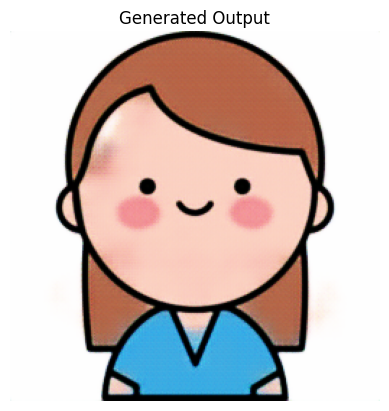

In [ ]:
plt.imshow(y.permute(1, 2, 0).numpy())
plt.axis("off")
plt.title("Generated Output")
plt.show()

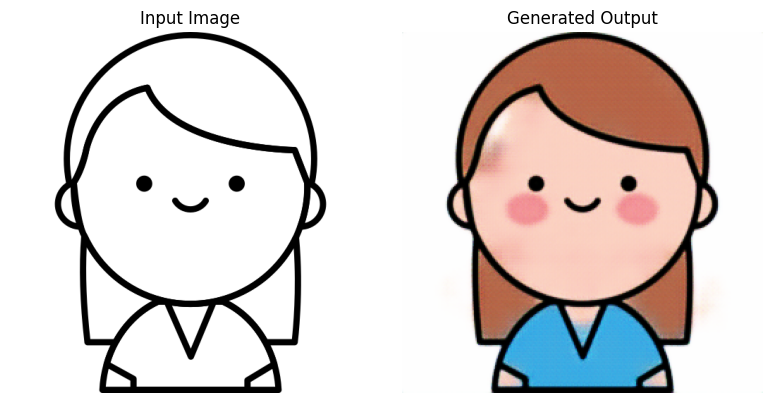

In [ ]:
orig = Image.open(img_path).convert('RGB')

fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].imshow(orig)
axes[0].axis("off")
axes[0].set_title("Input Image")

axes[1].imshow(y.permute(1, 2, 0).numpy())
axes[1].axis("off")
axes[1].set_title("Generated Output")

plt.tight_layout()
plt.show()
